# EV バッテリ劣化抑制 — 放置予測 EDA Notebook

このノートブックは `データ抽出Step.md` に記載された分析ステップを Jupyter 上で再現するためのテンプレートです。下記セルを順に実行すると、長時間放置クラスタの分析・充電前後遷移の可視化・日次遷移行列など、PoC 向けの EDA 出力を得られます。

## 0. 事前準備

- `eda_ev_parking_behavior.py` と同じディレクトリで実行します。
- 依存ライブラリが未導入の場合は、以下のセルのコメントアウトを外してライブラリをインストールしてください。
- デフォルトではサンプル CSV (`EV_Sessions_Test__first_20_rows.csv`) を読み込み、出力は `outputs/` 配下に保存されます。

In [ ]:
# 依存ライブラリが未インストールの場合はコメントアウトを外して実行してください。
# %pip install pandas matplotlib seaborn networkx scipy

In [ ]:
from pathlib import Path
import pandas as pd
from eda_ev_parking_behavior import (
    setup_plot_style,
    load_sessions,
    prepare_sessions,
    ensure_dirs,
    step1_long_park_distribution,
    step2_heatmaps_and_charge_effects,
    step3_transition_analysis,
)

# 入出力設定
data_path = Path("ev_sessions_test.csv")  # 必要に応じて差し替え
output_root = Path("outputs")
plots_dir, tables_dir = ensure_dirs(output_root)


In [ ]:
# Notebook から matplotlib の日本語フォントを設定
setup_plot_style()


## 1. データ読み込みと前処理

In [4]:
raw_df = load_sessions(data_path)
sessions_df = prepare_sessions(raw_df)
print(f"Loaded {len(sessions_df)} sessions from {data_path}")
sessions_df.head()

Loaded 122 sessions from ev_sessions_test.csv


,hashvin,session_cluster,session_type,start_time,end_time,duration_minutes,start_soc,end_soc,change_soc,start_lat,...,is_long_park,prev_session_type,prev_cluster,prev_is_long_park,next_session_type,next_cluster,next_is_long_park,after_charge,charge_start_hour,charge_cluster
0,hv_0001_demo,101,inactive,2025-08-31 20:30:00,2025-09-01 07:30:00,660.0,80.0,79.5,-0.5,35.68,...,True,NaN,NaN,NaN,inactive,202.0,True,False,NaN,NaN
1,hv_0001_demo,202,inactive,2025-09-01 09:00:00,2025-09-01 17:30:00,510.0,79.5,78.6,-0.9,35.69,...,True,inactive,101.0,True,inactive,303.0,False,False,NaN,NaN
2,hv_0001_demo,303,inactive,2025-09-01 18:00:00,2025-09-01 18:39:00,39.0,78.6,78.4,-0.1,35.66,...,False,inactive,202.0,True,inactive,101.0,True,False,NaN,NaN
3,hv_0001_demo,101,inactive,2025-09-01 20:30:00,2025-09-02 07:30:00,660.0,78.4,78.2,-0.2,35.68,...,True,inactive,303.0,False,inactive,202.0,True,False,NaN,NaN
4,hv_0001_demo,202,inactive,2025-09-02 09:00:00,2025-09-02 17:30:00,510.0,78.2,77.2,-1.0,35.69,...,True,inactive,101.0,True,inactive,303.0,False,False,NaN,NaN


## 2. Step1 — 長時間放置クラスタ分布 (Bar Plot)

In [8]:
focus_clusters = step1_long_park_distribution(
    sessions_df,
    plots_dir=plots_dir,
    tables_dir=tables_dir,
    per_vehicle_top_n=10,
    global_top_k=5,
)
print("Focus clusters (Step2対象):", focus_clusters)
pd.read_csv(tables_dir / "long_park_cluster_total_hours.csv").head()

findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans JP' not found.
findfont: Font family 'TakaoPGothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans JP' not found.
findfont: Font family 'TakaoPGothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 

Focus clusters (Step2対象): [101, 202]


,session_cluster,total_hours
0,101,330.0
1,202,187.0


## 3. Step2 — クラスタ別ヒートマップ & 充電開始時刻の影響

15分スロットを母数に滞在比率を算出します。ヒートマップの `n` は各セルに含まれるスロット数です。


/Users/horikeifutoshita/src/ml-study/EV-Battery-Parking-Degradation-Mitigation/eda/eda_ev_parking_behavior.py:189: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  lambda row: pd.date_range(
/Users/horikeifutoshita/src/ml-study/EV-Battery-Parking-Degradation-Mitigation/eda/eda_ev_parking_behavior.py:221: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5%
(n=20)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot.loc[idx, col] = (
/Users/horikeifutoshita/src/ml-study/EV-Battery-Parking-Degradation-Mitigation/eda/eda_ev_parking_behavior.py:221: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5%
(n=20)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot.loc[idx, col] = (
/Users/horik

KeyboardInterrupt: 

findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans JP' not found.
findfont: Font family 'TakaoPGothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 'Noto Sans JP' not found.
findfont: Font family 'TakaoPGothic' not found.
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAPGothic' not found.
findfont: Font family 'Yu Gothic' not found.
findfont: Font family 'Meiryo' not found.
findfont: Font family 'Noto Sans CJK JP' not found.
findfont: Font family 

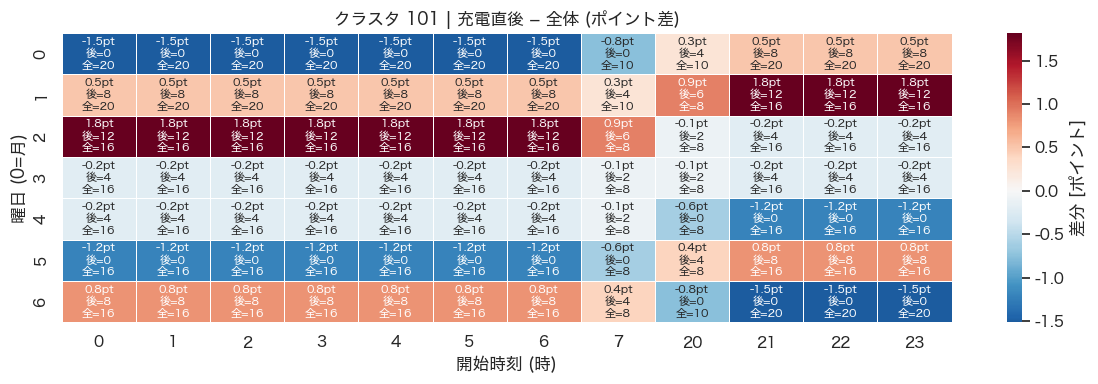

In [9]:
step2_heatmaps_and_charge_effects(
    sessions_df,
    focus_clusters=focus_clusters,
    plots_dir=plots_dir,
    tables_dir=tables_dir,
    freq_minutes=15,
)
print("Step2 completed. Generated heatmaps and conditional probability tables.")

## 4. Step3 — 充電前後遷移 & 日次遷移比較

In [5]:
step3_transition_analysis(
    sessions_df,
    plots_dir=plots_dir,
    tables_dir=tables_dir,
)
print("Step3 completed. Transition networks, matrices, and distance metrics saved.")

/Users/horikeifutoshita/src/ml-study/EV-Battery-Parking-Degradation-Mitigation/eda/eda_ev_parking_behavior.py:451: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  transitions["has_charge"] = transitions["has_charge"].fillna(False)


Step3 completed. Transition networks, matrices, and distance metrics saved.


/Users/horikeifutoshita/src/ml-study/ml-venv/lib/python3.11/site-packages/scipy/spatial/distance.py:1379: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)


## 5. 出力確認

Generated plot files:
- outputs/plots/bar_cluster_distribution_hv_0001_demo.png
- outputs/plots/charge_start_hour_next_long_cluster.png
- outputs/plots/heatmap_cluster_101_aftercharge.png
- outputs/plots/heatmap_cluster_101_all.png
- outputs/plots/heatmap_cluster_101_diff.png
- outputs/plots/heatmap_cluster_202_aftercharge.png
- outputs/plots/heatmap_cluster_202_all.png
- outputs/plots/heatmap_cluster_202_diff.png
- outputs/plots/network_after_charge.png
- outputs/plots/network_before_charge.png
- outputs/plots/transition_matrix_charge.png
- outputs/plots/transition_matrix_diff.png
- outputs/plots/transition_matrix_nocharge.png

Generated table files:
- outputs/tables/charge_start_to_next_long_cluster.csv
- outputs/tables/focus_cluster_slot_hours.csv
- outputs/tables/heatmap_cluster_101_aftercharge.csv
- outputs/tables/heatmap_cluster_101_all.csv
- outputs/tables/heatmap_cluster_101_diff.csv
- outputs/tables/heatmap_cluster_202_aftercharge.csv
- outputs/tables/heatmap_cluster_202_all.c

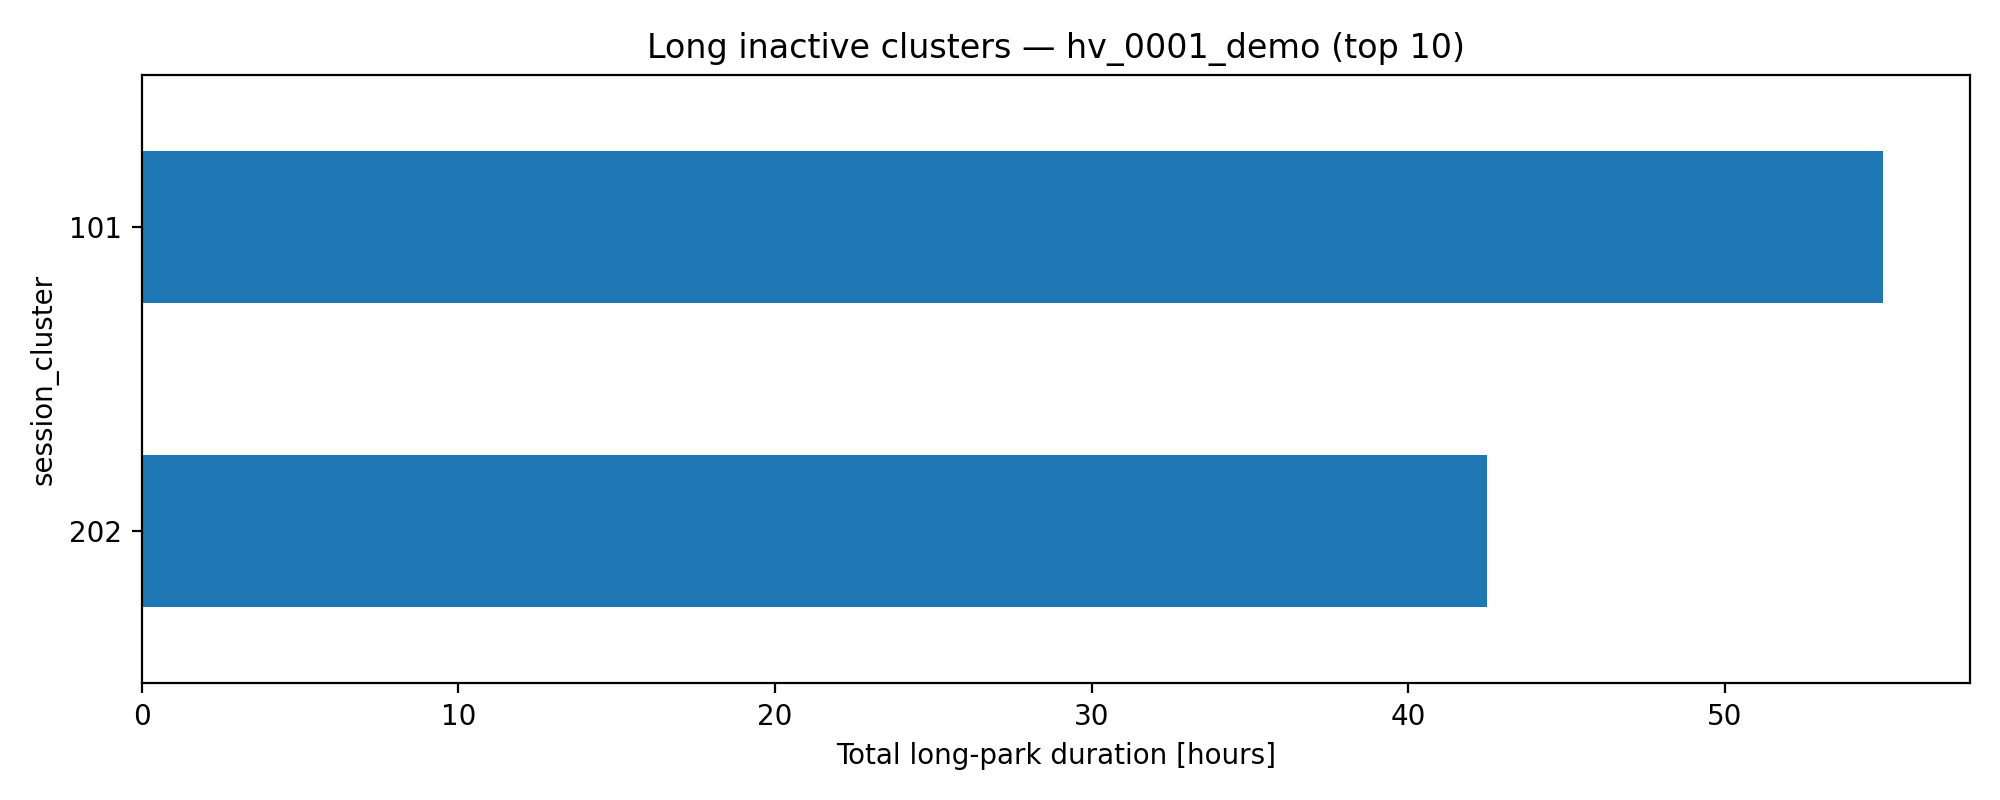

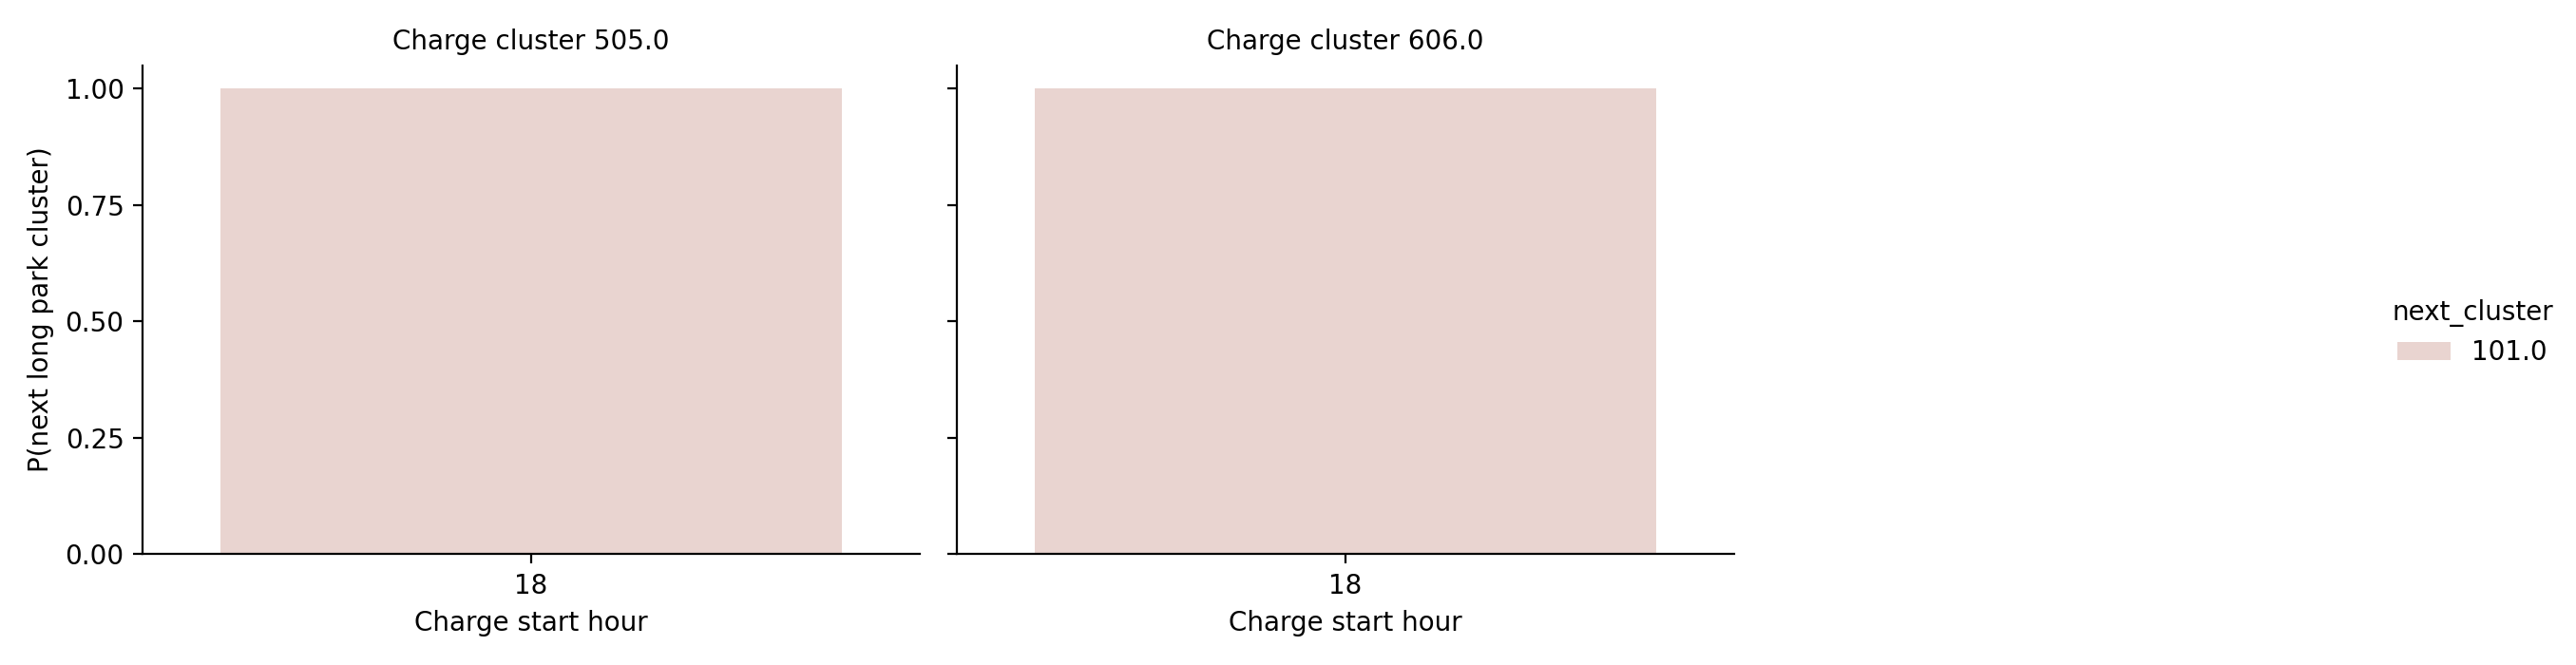

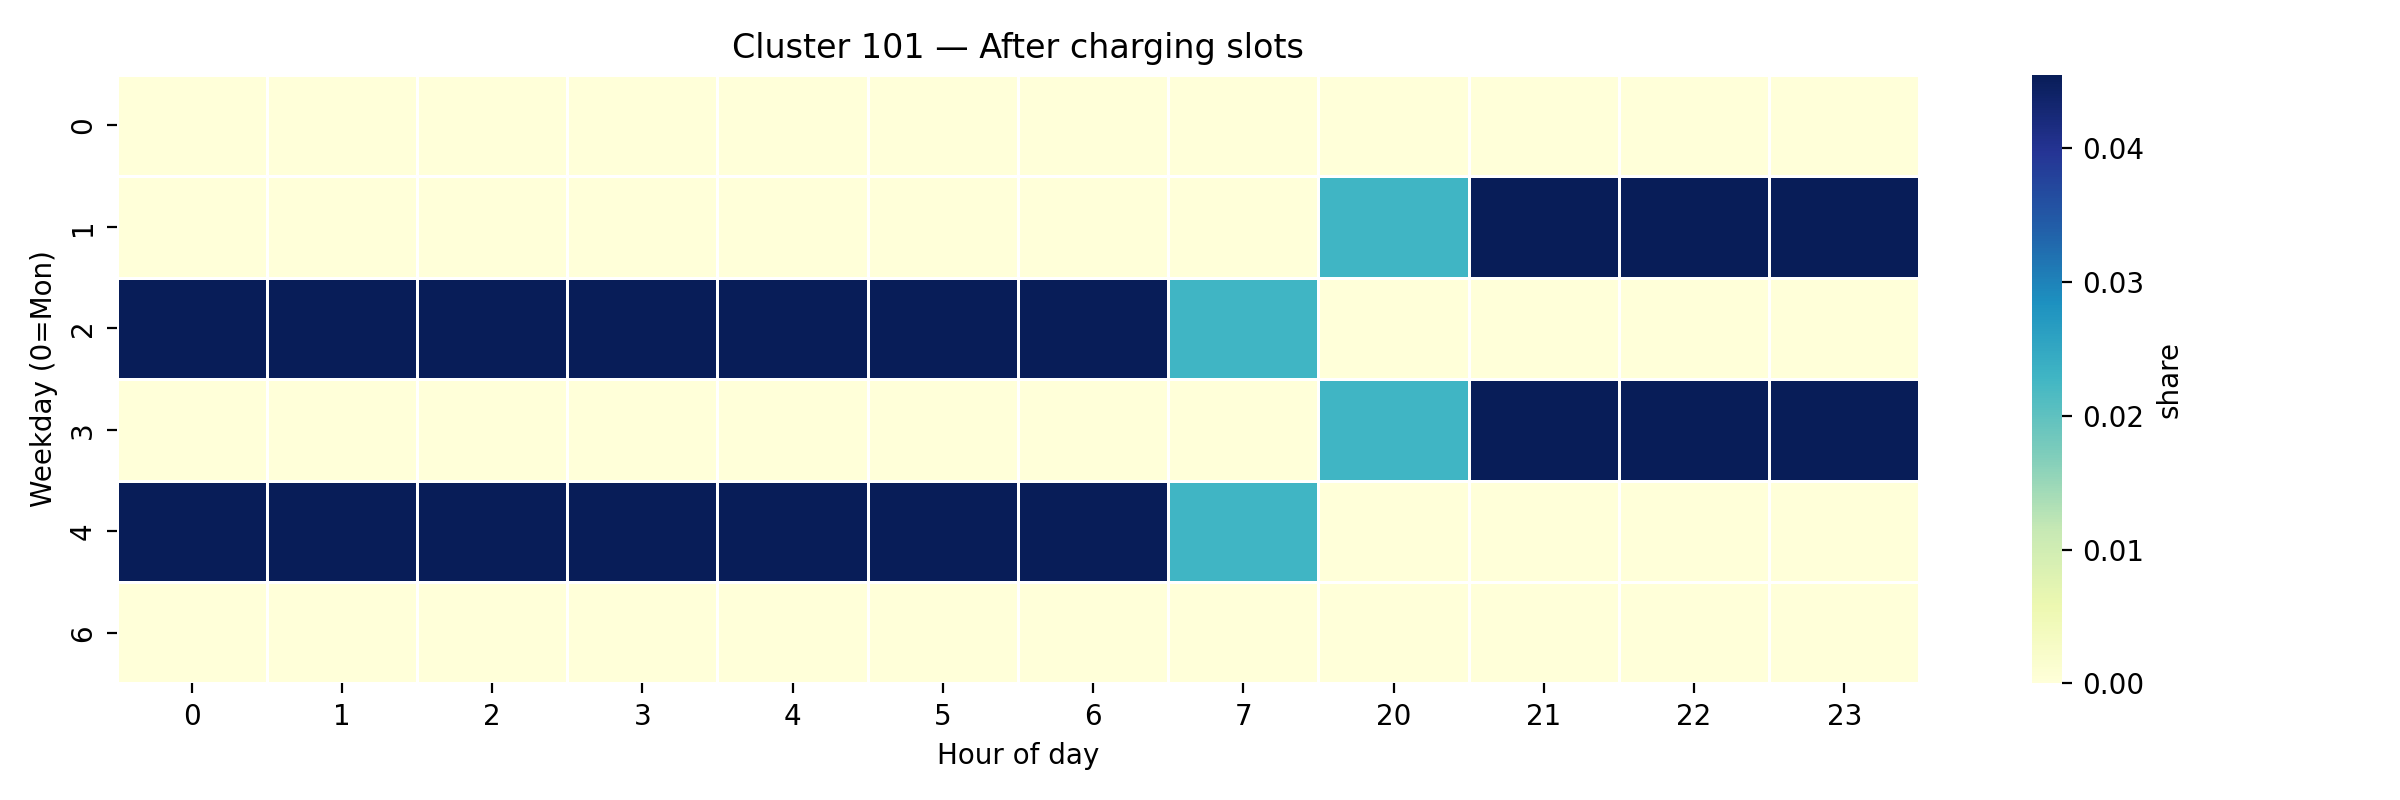

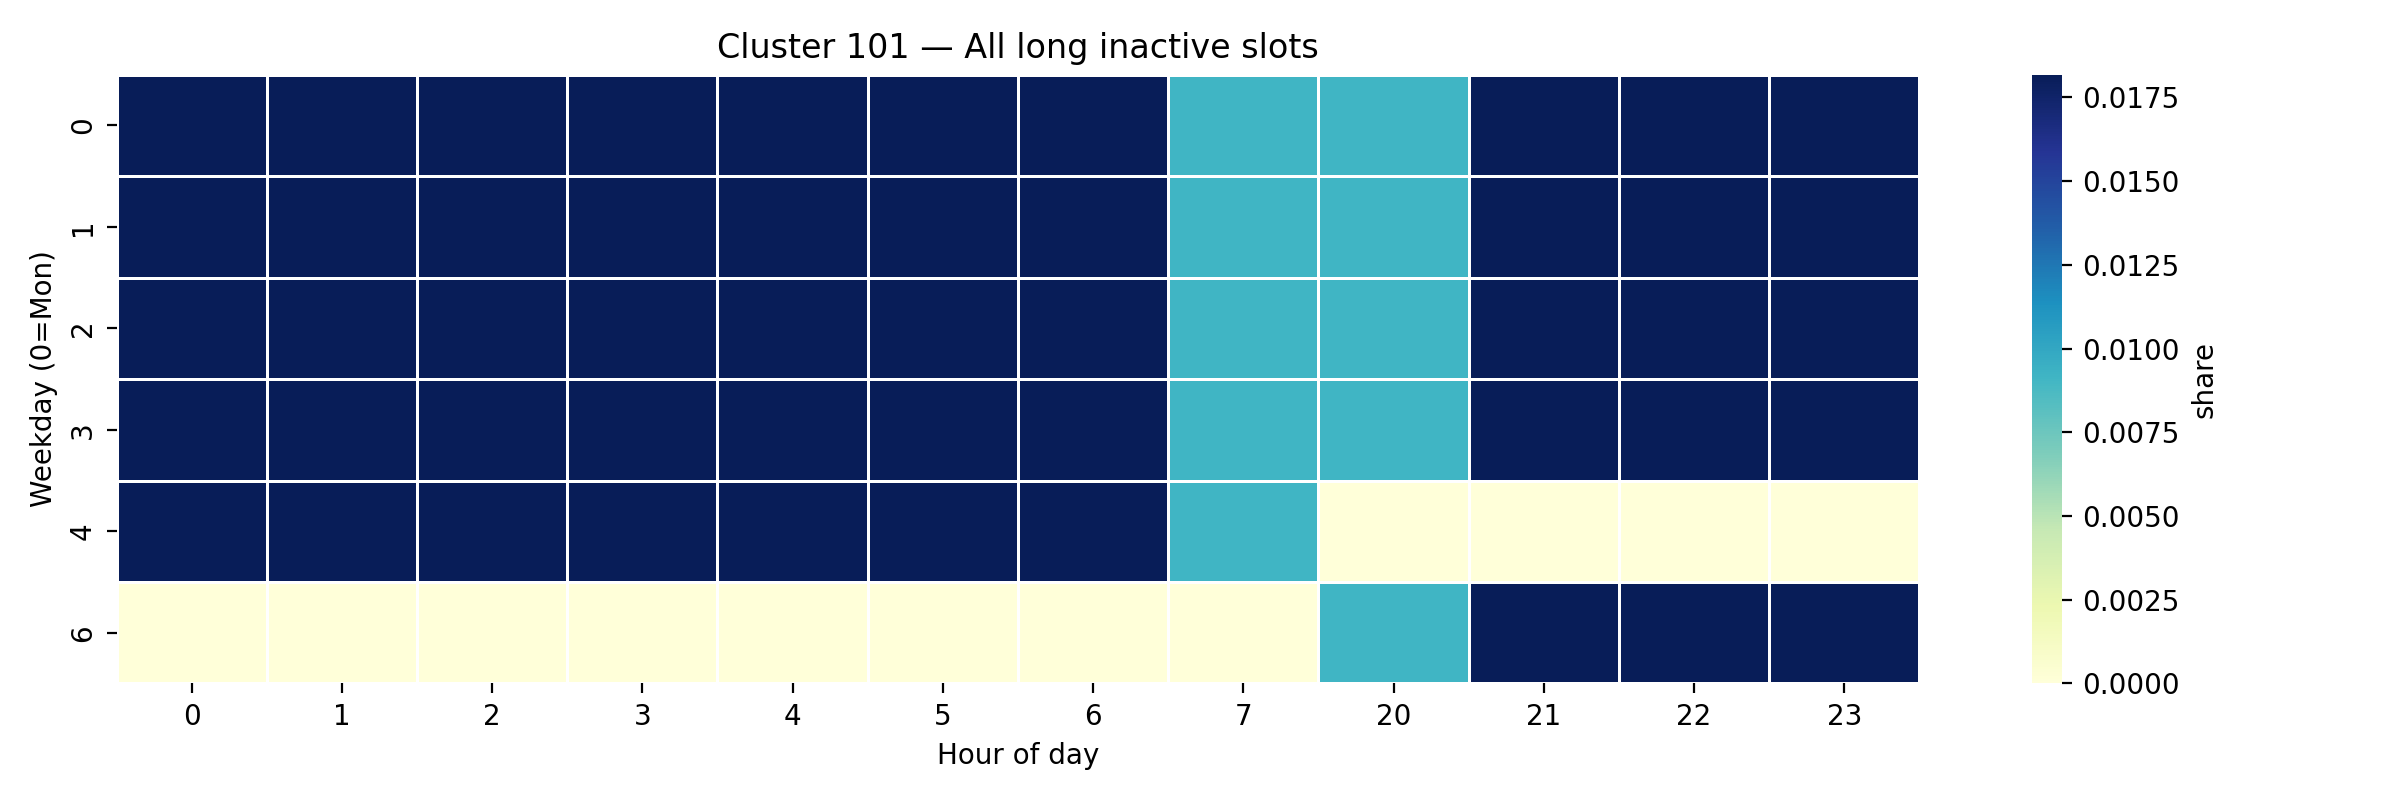

In [6]:
print("Generated plot files:")
for path in sorted(plots_dir.glob("*.png")):
    print("-", path)
print("\nGenerated table files:")
for path in sorted(tables_dir.glob("*.csv")):
    print("-", path)

# 代表的な図表を Notebook 上でプレビュー
preview_targets = [p for p in sorted(plots_dir.glob("*.png"))][:4]
for img_path in preview_targets:
    display(Image(filename=str(img_path)))

## 6. 次のステップ例

- `data_path` を実データの CSV やパーティションに差し替える。
- `output_root` を変えることで、車両 ID や実験条件ごとに成果物を整理可能。
- 生成された `tables/` の集計結果を特徴量エンジニアリングに転用。
- 必要に応じて可視化設定（色・閾値・クラスタ数など）を調整。